# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

In [1]:
!pip install fastai2

In [0]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
import gc

### fastai U-Net on these static images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/miccai2020/myops/png"

In [5]:
np.random.seed(42)
ids = np.arange(101,151)
np.random.shuffle(ids)
ids = np.reshape(ids,(-1,10))
ids

array([[114, 140, 131, 146, 118, 149, 127, 126, 133, 120],
       [113, 105, 138, 109, 104, 107, 142, 147, 148, 116],
       [110, 117, 125, 135, 132, 101, 145, 128, 134, 106],
       [130, 112, 137, 102, 122, 103, 144, 136, 124, 141],
       [111, 123, 119, 150, 121, 108, 143, 115, 129, 139]])

In [0]:
def getMyopsDls(val_ids):
  myopsData = DataBlock(blocks=(ImageBlock, MaskBlock(codes = ['bg','lv','my','rv','ed','sc'])),
      get_items=get_image_files,
      splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in val_ids),
      get_y=lambda o: str(o).replace("images","masks"),
      item_tfms=Resize(256),
      batch_tfms=aug_transforms(max_rotate=90))
  return myopsData.dataloaders(f'{path}/images',num_workers=8,batch_size=8)

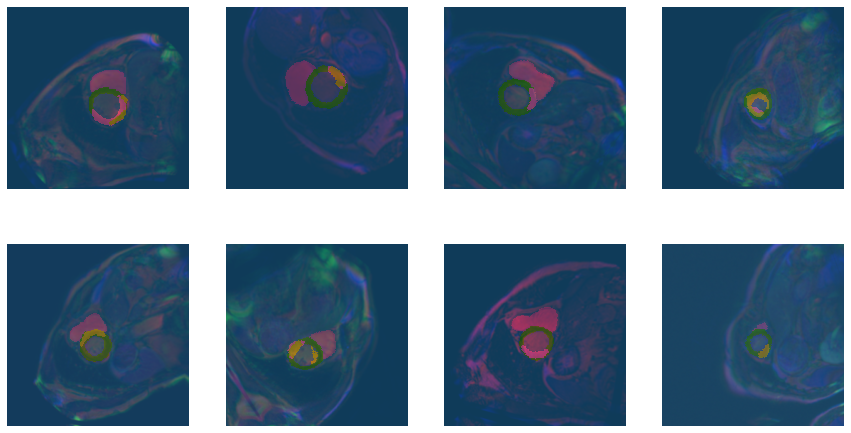

In [7]:
getMyopsDls(ids[0]).show_batch(figsize=(15,8))

In [0]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

#dice0inv = partial(multi_dice, class_id=0, inverse=True)
#dice1 = partial(multi_dice, class_id=1)
#dice2 = partial(multi_dice, class_id=2)
#dice3 = partial(multi_dice, class_id=3)
#dice4 = partial(multi_dice, class_id=4)
#dice5 = partial(multi_dice, class_id=5)
def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [0]:
def standard_trained_learner_cv(dl):
  learn = unet_learner(dl, resnet34, metrics=[foreground_acc, *dices], cbs=CSVLogger(fname="/content/drive/My Drive/miccai2020/myops/00_simple_unet_resnet34.trainLog.csv",append=True))
  learn.lr_find()
  learn.fit_one_cycle(10,lr_max=1e-3)
  learn.unfreeze()
  learn.lr_find()
  learn.fit_one_cycle(10,lr_max=1e-4)
  return learn

In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

/usr/local/lib/python3.6/dist-packages/pandas/util/__init__.py:23: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:102: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Tensor: GPU pinned 8 × 2 × 3
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8
TensorImage: GPU pinned 8
Total size: 192


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.200750,0.068450,0.527611,0.696764,0.518441,0.408269,0.214286,0.071429,01:31
1,0.084327,0.052149,0.698981,0.868668,0.671742,0.572868,0.173469,0.140891,01:15
2,0.191144,0.145964,0.000000,0.000000,0.000000,0.214286,0.214286,0.071429,01:15
3,0.096219,0.042400,0.669514,0.818660,0.634310,0.604869,0.106586,0.080418,01:14
4,0.065213,0.052525,0.568419,0.809835,0.459380,0.517851,0.214286,0.071429,01:13
5,0.049518,0.036655,0.711357,0.854578,0.695497,0.638445,0.098763,0.077370,01:13
6,0.041876,0.034767,0.722619,0.849472,0.674033,0.712360,0.214286,0.185045,01:13
7,0.038045,0.032428,0.753890,0.862901,0.704069,0.708915,0.118730,0.212980,01:13
8,0.035917,0.031811,0.753506,0.859933,0.703397,0.735456,0.197282,0.211627,01:13
9,0.035419,0.031401,0.755846,0.861528,0.706107,0.731839,0.175661,0.219392,01:14


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.035467,0.031123,0.762273,0.861542,0.707466,0.747373,0.175346,0.238066,01:17
1,0.035206,0.031185,0.768149,0.873828,0.703960,0.715176,0.214286,0.264832,01:17
2,0.035314,0.031258,0.767487,0.872768,0.707836,0.719915,0.195694,0.231125,01:17
3,0.034706,0.028725,0.786294,0.863443,0.723060,0.751362,0.180323,0.304201,01:17
4,0.032800,0.029490,0.766208,0.872465,0.708785,0.753157,0.183021,0.270007,01:17
5,0.031358,0.030208,0.794510,0.870663,0.704135,0.736447,0.208673,0.313272,01:17
6,0.030940,0.029539,0.784825,0.869727,0.710436,0.779229,0.173239,0.299451,01:17
7,0.030264,0.028149,0.780299,0.873098,0.722014,0.748676,0.202974,0.310443,01:17
8,0.029298,0.028023,0.778611,0.874044,0.721995,0.815962,0.203395,0.326461,01:17
9,0.029372,0.027815,0.781965,0.874209,0.721815,0.831085,0.203000,0.326986,01:18


Tensor: GPU pinned 8 × 2 × 3
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8
TensorImage: GPU pinned 8
Tensor: GPU pinned 1 × 3 × 1 × 1
Tensor: GPU pinned 1 × 3 × 1 × 1
Tensor: GPU pinned 34 × 2 × 3
Tensor: GPU pinned 34 × 4 × 2
Tensor: GPU pinned 34 × 4 × 2
TensorImage: GPU pinned 34
Tensor: GPU pinned 34
Total size: 1014


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.159150,0.122449,0.296721,0.610352,0.275354,0.215152,0.208333,0.279762,01:18
1,0.083510,0.048556,0.750382,0.821330,0.596865,0.703403,0.177498,0.260104,01:09
2,0.057135,0.039980,0.687551,0.837966,0.653254,0.746111,0.180450,0.380746,01:09
3,0.044902,0.034429,0.800701,0.853638,0.719434,0.777977,0.164124,0.353458,01:09
4,0.038091,0.031723,0.780937,0.836242,0.677649,0.800402,0.137188,0.390468,01:09
5,0.038049,0.041807,0.711806,0.816391,0.650253,0.804446,0.137412,0.338667,01:09
6,0.034301,0.032643,0.798079,0.857724,0.690583,0.798749,0.103497,0.384672,01:09
7,0.031766,0.030735,0.763870,0.854379,0.674000,0.828040,0.111072,0.410414,01:09
8,0.028934,0.029981,0.775164,0.862140,0.682587,0.827974,0.116582,0.467075,01:09
9,0.026892,0.030109,0.784765,0.862272,0.694576,0.817618,0.121883,0.437384,01:09


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.027385,0.030307,0.780417,0.860988,0.688920,0.816350,0.123884,0.456817,01:13
1,0.026737,0.031772,0.773178,0.861159,0.665518,0.844108,0.101877,0.417806,01:13
2,0.028897,0.032974,0.777844,0.847301,0.709038,0.818613,0.120390,0.434263,01:13
3,0.027203,0.030905,0.797087,0.851656,0.713638,0.824988,0.122743,0.480466,01:13
4,0.025771,0.031754,0.762292,0.861074,0.671259,0.822957,0.166501,0.458723,01:13
5,0.024646,0.030219,0.791414,0.866657,0.701692,0.844759,0.144652,0.447739,01:13
6,0.024610,0.029143,0.804458,0.866286,0.730947,0.834698,0.188590,0.459559,01:13
7,0.022585,0.030343,0.782468,0.867143,0.692839,0.835482,0.176146,0.437289,01:13
8,0.022517,0.029510,0.795175,0.867556,0.715816,0.837960,0.162062,0.444528,01:13
9,0.022670,0.029424,0.791017,0.867219,0.710632,0.835997,0.168306,0.442223,01:13


Tensor: GPU pinned 8 × 2 × 3
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8
TensorImage: GPU pinned 8
Tensor: GPU pinned 1 × 3 × 1 × 1
Tensor: GPU pinned 1 × 3 × 1 × 1
Tensor: GPU pinned 40 × 2 × 3
Tensor: GPU pinned 40 × 4 × 2
Tensor: GPU pinned 40 × 4 × 2
TensorImage: GPU pinned 40
Tensor: GPU pinned 40
Total size: 1158


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.226751,0.076858,0.375125,0.664115,0.061416,0.383542,0.173913,0.173913,01:18
1,0.096432,0.047893,0.672789,0.740906,0.593077,0.649195,0.132922,0.187039,01:10
2,0.058832,0.039776,0.630804,0.820594,0.629630,0.644964,0.165562,0.329627,01:10
3,0.044466,0.034599,0.731630,0.825296,0.668531,0.741586,0.188200,0.374848,01:10
4,0.038630,0.038269,0.766883,0.842251,0.710470,0.752747,0.178147,0.469012,01:10
5,0.035216,0.031995,0.746091,0.850041,0.700735,0.736977,0.182538,0.454980,01:10
6,0.031956,0.029314,0.751828,0.842897,0.709008,0.760217,0.216449,0.455122,01:10
7,0.029063,0.030166,0.738540,0.839381,0.701636,0.749206,0.208179,0.464708,01:10
8,0.028130,0.029373,0.747620,0.841717,0.707514,0.741270,0.243691,0.463937,01:10
9,0.027196,0.028715,0.754988,0.848618,0.717073,0.748329,0.246380,0.472853,01:10


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.026457,0.031657,0.746594,0.841733,0.708766,0.754080,0.223272,0.468550,01:13
1,0.027419,0.031385,0.726099,0.830328,0.682005,0.726346,0.239033,0.455569,01:14
2,0.027597,0.029815,0.757069,0.856359,0.726982,0.758183,0.260429,0.476889,01:13
3,0.026697,0.028818,0.778600,0.864671,0.724038,0.758308,0.261180,0.461783,01:13
4,0.027269,0.030166,0.759319,0.865902,0.717079,0.767394,0.254823,0.486440,01:13
5,0.025559,0.028252,0.765205,0.860915,0.731567,0.768882,0.299378,0.451712,01:13
6,0.024393,0.027125,0.778840,0.865179,0.745757,0.773068,0.262122,0.480359,01:14
7,0.023505,0.027334,0.775439,0.861146,0.740849,0.768878,0.264978,0.476644,01:13
8,0.022572,0.027768,0.767683,0.860311,0.733186,0.765142,0.282279,0.475840,01:13
9,0.022563,0.027902,0.769960,0.862842,0.733461,0.765565,0.288923,0.475174,01:14


Tensor: GPU pinned 8 × 2 × 3
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8
TensorImage: GPU pinned 8
Tensor: GPU pinned 1 × 3 × 1 × 1
Tensor: GPU pinned 1 × 3 × 1 × 1
Tensor: GPU pinned 33 × 2 × 3
Tensor: GPU pinned 33 × 4 × 2
Tensor: GPU pinned 33 × 4 × 2
TensorImage: GPU pinned 33
Tensor: GPU pinned 33
Total size: 990


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.185475,0.096466,0.475741,0.611908,0.403050,0.410109,0.050000,0.050636,01:17
1,0.084771,0.050131,0.650804,0.827779,0.608387,0.697061,0.072035,0.116391,01:11
2,0.058085,0.044001,0.731719,0.851988,0.663944,0.812759,0.050000,0.197617,01:10
3,0.043842,0.039390,0.767041,0.859767,0.672708,0.836261,0.050058,0.297199,01:10
4,0.037484,0.039824,0.741370,0.860703,0.657256,0.829275,0.050112,0.382500,01:10
5,0.035156,0.036902,0.750527,0.871303,0.677968,0.830471,0.051245,0.425451,01:10
6,0.032287,0.033245,0.779897,0.882006,0.699076,0.851872,0.089168,0.520289,01:11
7,0.030257,0.033141,0.797534,0.883274,0.699967,0.852305,0.138543,0.489865,01:10
8,0.028072,0.032882,0.780596,0.890282,0.700266,0.840164,0.142242,0.491522,01:10
9,0.026367,0.032915,0.775807,0.889244,0.691097,0.844556,0.169447,0.499311,01:11


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.026328,0.032789,0.768086,0.892132,0.696003,0.834270,0.165316,0.509885,01:14
1,0.026468,0.032685,0.783285,0.884895,0.681781,0.855793,0.223734,0.499062,01:14
2,0.027126,0.034578,0.757922,0.878620,0.686770,0.837425,0.089481,0.514856,01:14
3,0.027411,0.031709,0.784374,0.889824,0.704578,0.857189,0.170914,0.532144,01:14
4,0.025299,0.032842,0.777312,0.876737,0.696997,0.852328,0.204934,0.511801,01:15
5,0.024293,0.032022,0.776344,0.889419,0.711685,0.845165,0.189990,0.538091,01:15
6,0.024184,0.031642,0.793985,0.889743,0.710587,0.863812,0.227086,0.527791,01:15
7,0.023204,0.031254,0.800742,0.889273,0.720524,0.858745,0.203961,0.492612,01:15
8,0.022039,0.031132,0.793486,0.890891,0.716953,0.852247,0.226664,0.519316,01:15
9,0.021703,0.031120,0.796647,0.890927,0.718646,0.857815,0.232901,0.514051,01:14


Tensor: GPU pinned 8 × 2 × 3
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8 × 4 × 2
Tensor: GPU pinned 8
TensorImage: GPU pinned 8
Tensor: GPU pinned 1 × 3 × 1 × 1
Tensor: GPU pinned 1 × 3 × 1 × 1
Tensor: GPU pinned 12 × 2 × 3
Tensor: GPU pinned 12 × 4 × 2
Tensor: GPU pinned 12 × 4 × 2
TensorImage: GPU pinned 12
Tensor: GPU pinned 12
Total size: 486


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.220084,0.089423,0.429444,0.687795,0.309947,0.447997,0.095238,0.000000,01:17
1,0.088708,0.050354,0.684360,0.812153,0.582141,0.791854,0.071803,0.106053,01:11
2,0.055140,0.045697,0.736881,0.802409,0.625623,0.786992,0.096465,0.152256,01:11
3,0.041289,0.046687,0.710479,0.796109,0.623455,0.760039,0.065155,0.034555,01:10
4,0.035589,0.039385,0.741185,0.836283,0.659379,0.829172,0.192757,0.363482,01:11
5,0.034977,0.040770,0.751992,0.821236,0.658006,0.782408,0.171446,0.316364,01:10
6,0.031469,0.038675,0.745749,0.835646,0.650773,0.826554,0.194488,0.446039,01:10
7,0.028136,0.037368,0.762254,0.834352,0.663185,0.794223,0.191689,0.425219,01:10
8,0.026180,0.035653,0.763566,0.850541,0.675286,0.813074,0.225553,0.437769,01:10
9,0.025223,0.035813,0.761173,0.848174,0.670867,0.810414,0.216571,0.453386,01:10


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.024721,0.036952,0.763849,0.849054,0.680717,0.804433,0.222776,0.447054,01:14
1,0.026002,0.039662,0.741570,0.841159,0.647579,0.800117,0.245873,0.378369,01:14
2,0.026471,0.036814,0.746305,0.843097,0.660052,0.786064,0.183357,0.491031,01:14
3,0.025074,0.034764,0.760161,0.843737,0.673085,0.800451,0.257221,0.446280,01:14
4,0.024221,0.035732,0.768618,0.851750,0.688652,0.809558,0.226917,0.437915,01:14
5,0.023602,0.034687,0.773785,0.853623,0.694060,0.808674,0.244316,0.443027,01:14
6,0.022294,0.035880,0.779468,0.858911,0.684778,0.814146,0.227080,0.480411,01:14
7,0.021251,0.036627,0.765526,0.859847,0.670475,0.815856,0.259832,0.444962,01:14
8,0.020613,0.035484,0.769999,0.859484,0.679734,0.814508,0.263982,0.452730,01:14
9,0.021105,0.035424,0.765676,0.860251,0.677727,0.813713,0.264843,0.446680,01:14


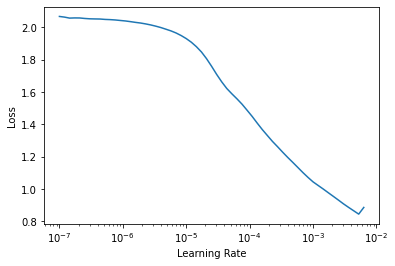

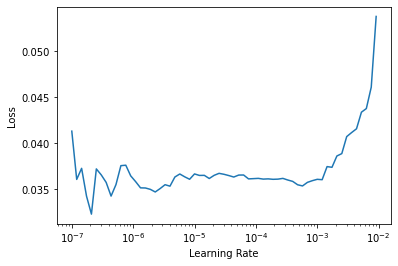

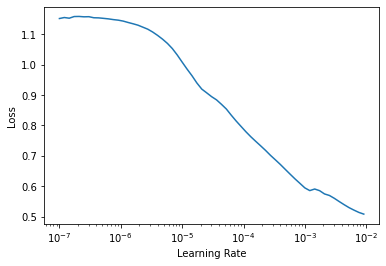

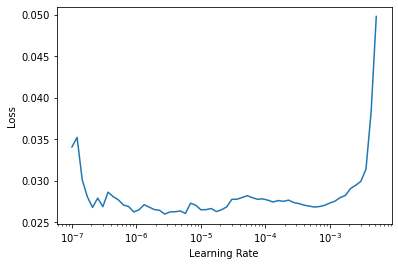

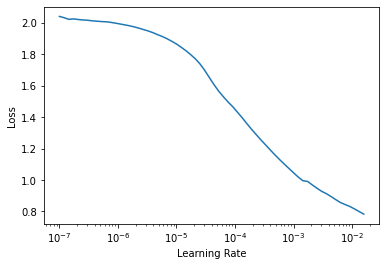

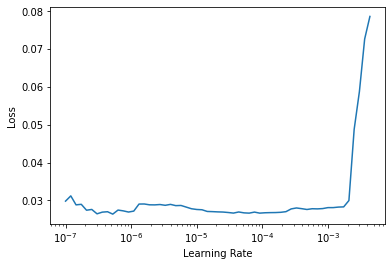

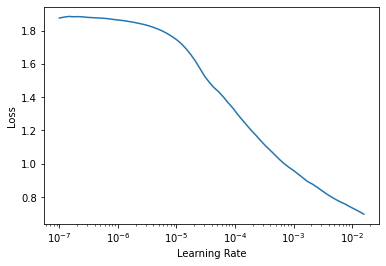

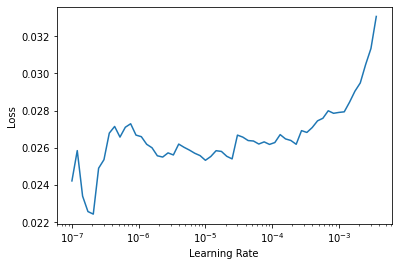

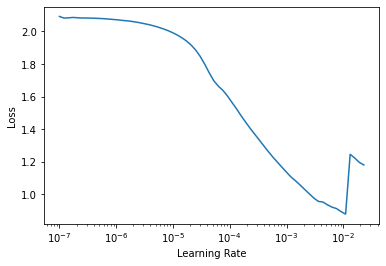

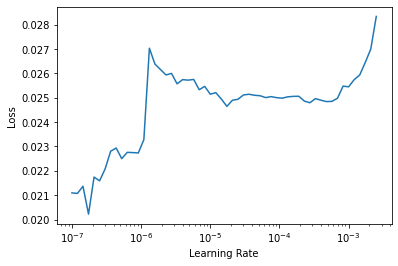

In [11]:
learn = None
dl = None
for x in ids:
  del learn
  del dl
  gc.collect()
  torch.cuda.empty_cache()
  dump_tensors()
  dl = getMyopsDls(x)
  learn = standard_trained_learner_cv(dl)

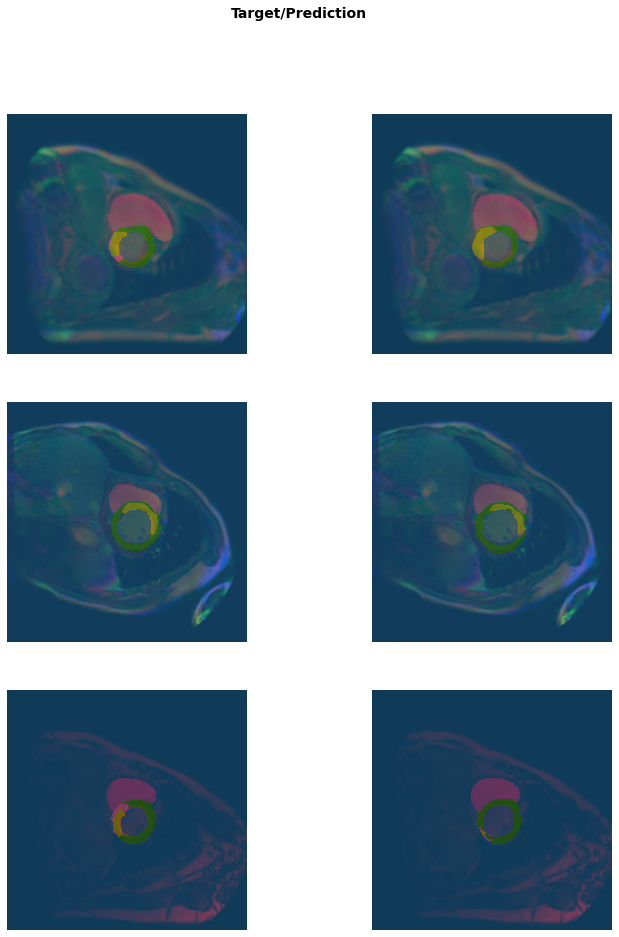

In [12]:
learn.show_results(figsize=(12,15))

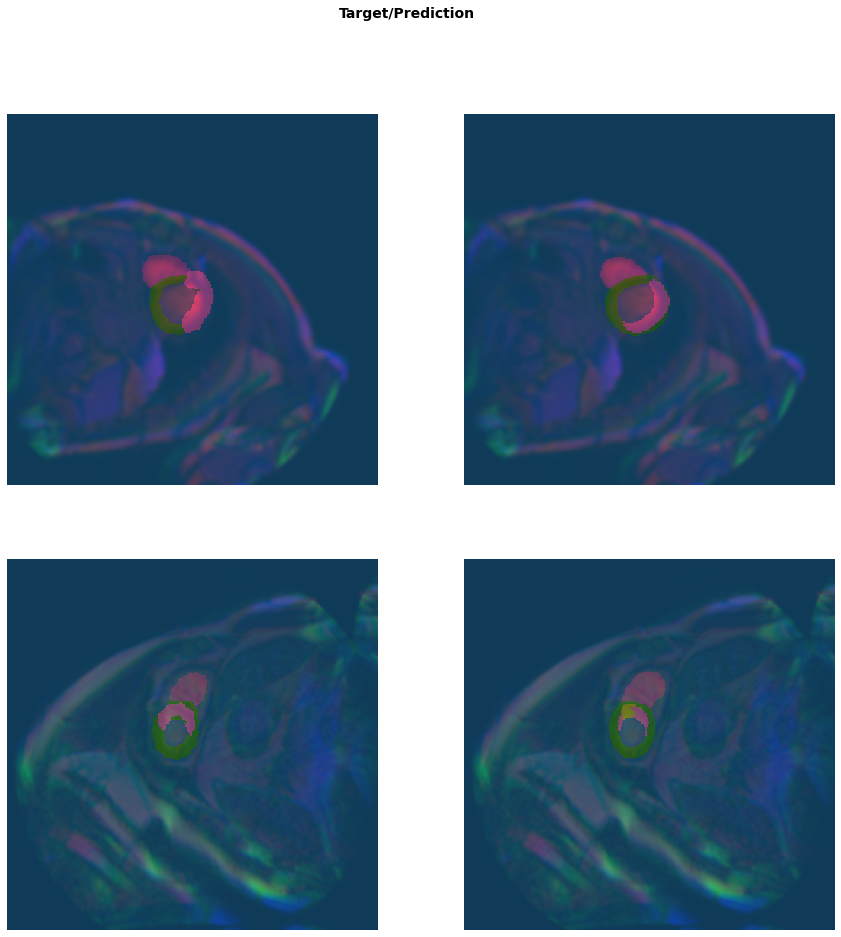

In [13]:
learn.show_results(ds_idx=0, figsize=(15,15))